# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import random

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="Banana.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

#### Tensorflow QNetwork

Below is the implementation of a QNetwork using tensorflow as the backend model. This contains a tensorflow session and after initially building the network graph, it is trained by running the optimizer with the state, action and q_target values for training.

In [1]:
import tensorflow as tf

class TFQNetwork():
    def __init__(self, state_size, action_size, load_path=None):
        self.build_model(state_size, action_size)
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        self.saver = tf.train.Saver()
        if load_path: self.load_model(load_path)
        
    def build_model(self, state_size, action_size):
        self.state_in = tf.placeholder(tf.float32, shape=[None, state_size])
        self.action_in = tf.placeholder(tf.int32, shape=[None])
        self.q_target_in = tf.placeholder(tf.float32, shape=[None])
        action_one_hot = tf.one_hot(self.action_in, depth=action_size)
        
        self.hidden1 = tf.layers.dense(self.state_in, 100, activation=tf.nn.relu)
        self.hidden2 = tf.layers.dense(self.hidden1, 100, activation=tf.nn.relu)
        self.q_state = tf.layers.dense(self.hidden2, self.action_size)
        self.q_state_action = tf.reduce_sum(tf.multiply(self.q_state, action_one_hot), axis=1)
        
        self.loss = tf.reduce_sum(tf.square(self.q_state_action - self.q_target_in))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(self.loss)

    def get_q_state(self, state):
        q_state = self.sess.run(self.q_state, feed_dict={self.state_in: state})
        return q_state
        
    def update_model(self, states, actions, q_targets):
        feed_dict={self.state_in: states, self.action_in: actions, self.q_target_in: q_targets}
        self.sess.run(self.optimizer, feed_dict)
        
    def save_model(self, path="checkpoint.ckpt"):
        saver.save(self.sess, path)
        
    def load_model(self, path="checkpoint.ckpt"):
        saver.restore(self.sess, path)
        
    def __del__(self):
        self.sess.close()

#### Pytorch QNetwork

Below is the implementation of a QNetwork using pytorch as the backend model. This involves first defining a Model class which subclasses the pytorch nn.Module class and then defines the network graph which can be run with the forward function.

Then the Model is included in an enclosing PTQNetwork class which trains the model by taking in the states and running the Model class to get the q values which are then indexed by the actions and then the gradients are calculated from the MSE loss between the predicted q value and the q_target.

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Model(nn.Module):
    def __init__(self, state_size, action_size):
        super().__init__()
        self.hidden1 = nn.Linear(state_size, 128)
        self.hidden2 = nn.Linear(128, 64)
        self.q_state = nn.Linear(64, action_size)

    def forward(self, state):
        hidden1 = F.relu(self.hidden1(state))
        hidden2 = F.relu(self.hidden2(hidden1))
        q_state = self.q_state(hidden2)
        return q_state

class PTQNetwork():
    def __init__(self, state_size, action_size, load_path=None):
        self.model = Model(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.0001)
        if load_path: self.load_model(load_path)

    def get_q_state(self, state):
        state = torch.from_numpy(np.array(state)).float()
        q_state = self.model(state).detach().numpy()
        return q_state
    
    def update_model(self, states, actions, q_targets):
        states = torch.from_numpy(np.vstack(states)).float()
        actions = torch.from_numpy(np.vstack(actions)).long()
        q_targets = torch.from_numpy(np.vstack(q_targets)).float()
        q_preds = self.model(states).gather(1, actions)
        loss = F.mse_loss(q_preds, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def save_model(self, path="checkpoint.pth"):
        torch.save(self.model.state_dict(), path)
        
    def load_model(self, path="checkpoint.pth"):
        self.model.load_state_dict(torch.load(path))

#### Experience Replay

Below is the implementation of a Replay Buffer using the deque collection as the rolling buffer of experience tuples. This can be sampled by specifying the sample size and then returns each individual experience type as separate lists.

In [12]:
from collections import deque

class ReplayBuffer():
    def __init__(self, maxlen):
        self.buffer = deque(maxlen=maxlen)
        
    def add(self, experience):
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        sample_size = min(len(self.buffer), batch_size)
        samples = random.choices(self.buffer, k=sample_size)
        return map(list, zip(*samples))

#### Agent

Below is the implementation of the agent that uses Deep Q Networks to learn the Bellman equation for selecting actions to take in a given state from the environment. It selects an action from an epsilon-greedy policy starting with eps = 1.0 which decreases as the network is trained.

In [13]:
class DQNAgent():
    # Initializing the agent and the model for selecting actions
    def __init__(self, state_size, action_size, load_path=None):
        # The number of state values in the state vector
        self.state_size = state_size
        # The number of action indices to select from
        self.action_size = action_size
        # Defining the q network to use for modeling the Bellman equation
        self.q_network = PTQNetwork(state_size, action_size, load_path)
        # Defining the replay buffer for experience replay
        self.replay_buffer = ReplayBuffer(50000)
        # Initializing the epsilon value to 1.0 for initial exploration
        self.eps = 1.0
        # The discount rate for the Bellman equation
        self.gamma = 0.97
        
    # Function for getting an action to take in the given state
    def get_action(self, state):
        # Get the q values for the state from the model
        q_state = self.q_network.get_q_state([state])
        # Save the greedy action of the index of the max q value
        action_greedy = np.argmax(q_state)
        # Save a randomly selected action
        action_random = np.random.randint(self.action_size)
        # Choose between the greedy and random action using epsilon
        action = action_random if random.random() < self.eps else action_greedy
        return action
        
    # Function for training the agent at each time step
    def train(self, state, action, next_state, reward, done):
        # First add the experience to the replay buffer
        self.replay_buffer.add((state, action, next_state, reward, done))
        # Sample a batch of each experience type from the replay buffer
        states, actions, next_states, rewards, dones = self.replay_buffer.sample(50)
        
        # Getting the q values for each next state
        q_next_states = self.q_network.get_q_state(next_states)
        # Adjusting the q values of terminal state to zeros
        q_next_states[dones] = np.zeros([self.action_size])
        # Calculating the target q value from the Bellman equation
        q_targets = rewards + self.gamma * np.max(q_next_states, axis=1)
        # Train the model with the q target
        self.q_network.update_model(states, actions, q_targets)

        # Decrease epsilon after each episode
        if done: self.eps = max(self.eps * 0.995, 0.1)

#### Training

Below is the training loop for training the agent through a number of episodes of interacting with the environment. It keeps track of the total reward from each episode and also stores the last 100 episode rewards for calculating the average reward for checking when the environment was solved.

In [14]:
# Create an agent instance
agent = DQNAgent(state_size, action_size)
# Define number of episodes to train for
num_episodes = 2000
# Create a buffer for calculating the last 100 episode average reward
scores_buffer = deque(maxlen=100)
# List to store each episode's total reward
scores = []
# List to store the average reward after each episode
avg_scores = []

# Run the training loop
for ep in range(num_episodes):
    # Reset the environment to get the initial state
    env_info = env.reset(train_mode=True)[brain_name]
    # Save the initial state
    state = env_info.vector_observations[0]
    # Reset the total reward
    total_reward = 0
    # Reset the episode terminal condition
    done = False
    while not done:
        # Query the agent for an action to take in the state
        action = agent.get_action(state)
        # Take the action in the environment
        env_info = env.step(action)[brain_name] 
        # Save the next state
        next_state = env_info.vector_observations[0]
        # Save the reward
        reward = env_info.rewards[0]    
        # Save the terminal condition update
        done = env_info.local_done[0]   
        # Train the agent with the new time step experience
        agent.train(state, action, next_state, reward, done)
        # Update the episode's total reward
        total_reward += reward             
        # Update the current state
        state = next_state 

    # Store the last episode's total reward
    scores.append(total_reward)
    # Add the total reward to the buffer for calculating average reward
    scores_buffer.append(total_reward)
    # Store the new average reward
    avg_scores.append(np.mean(scores_buffer))
    print("Episode: {}, Score: {}, Avg reward: {:.2f}".format(ep, scores[ep], avg_scores[ep]))

agent.q_network.save_model()

Episode: 0, Score: 0.0, Avg reward: 0.00
Episode: 1, Score: 1.0, Avg reward: 0.50
Episode: 2, Score: -1.0, Avg reward: 0.00
Episode: 3, Score: 0.0, Avg reward: 0.00
Episode: 4, Score: 1.0, Avg reward: 0.20
Episode: 5, Score: -1.0, Avg reward: 0.00
Episode: 6, Score: 0.0, Avg reward: 0.00
Episode: 7, Score: 2.0, Avg reward: 0.25
Episode: 8, Score: 3.0, Avg reward: 0.56
Episode: 9, Score: -2.0, Avg reward: 0.30
Episode: 10, Score: -1.0, Avg reward: 0.18
Episode: 11, Score: -1.0, Avg reward: 0.08
Episode: 12, Score: -1.0, Avg reward: 0.00
Episode: 13, Score: 0.0, Avg reward: 0.00
Episode: 14, Score: 0.0, Avg reward: 0.00
Episode: 15, Score: 0.0, Avg reward: 0.00
Episode: 16, Score: -1.0, Avg reward: -0.06
Episode: 17, Score: 0.0, Avg reward: -0.06
Episode: 18, Score: 0.0, Avg reward: -0.05
Episode: 19, Score: 1.0, Avg reward: 0.00
Episode: 20, Score: 0.0, Avg reward: 0.00
Episode: 21, Score: -1.0, Avg reward: -0.05
Episode: 22, Score: 0.0, Avg reward: -0.04
Episode: 23, Score: 1.0, Avg re

Episode: 193, Score: 8.0, Avg reward: 2.58
Episode: 194, Score: 3.0, Avg reward: 2.60
Episode: 195, Score: 4.0, Avg reward: 2.62
Episode: 196, Score: 10.0, Avg reward: 2.69
Episode: 197, Score: 3.0, Avg reward: 2.70
Episode: 198, Score: 2.0, Avg reward: 2.73
Episode: 199, Score: 7.0, Avg reward: 2.79
Episode: 200, Score: 6.0, Avg reward: 2.85
Episode: 201, Score: 2.0, Avg reward: 2.84
Episode: 202, Score: 7.0, Avg reward: 2.89
Episode: 203, Score: 7.0, Avg reward: 2.98
Episode: 204, Score: 6.0, Avg reward: 3.03
Episode: 205, Score: 5.0, Avg reward: 3.06
Episode: 206, Score: 4.0, Avg reward: 3.10
Episode: 207, Score: 5.0, Avg reward: 3.14
Episode: 208, Score: 0.0, Avg reward: 3.13
Episode: 209, Score: 4.0, Avg reward: 3.16
Episode: 210, Score: 3.0, Avg reward: 3.18
Episode: 211, Score: 5.0, Avg reward: 3.23
Episode: 212, Score: 7.0, Avg reward: 3.29
Episode: 213, Score: 4.0, Avg reward: 3.33
Episode: 214, Score: 7.0, Avg reward: 3.37
Episode: 215, Score: 9.0, Avg reward: 3.43
Episode: 2

Episode: 382, Score: 8.0, Avg reward: 10.29
Episode: 383, Score: 17.0, Avg reward: 10.39
Episode: 384, Score: 5.0, Avg reward: 10.41
Episode: 385, Score: 18.0, Avg reward: 10.51
Episode: 386, Score: 11.0, Avg reward: 10.54
Episode: 387, Score: 17.0, Avg reward: 10.64
Episode: 388, Score: 8.0, Avg reward: 10.61
Episode: 389, Score: 16.0, Avg reward: 10.62
Episode: 390, Score: 11.0, Avg reward: 10.67
Episode: 391, Score: 14.0, Avg reward: 10.73
Episode: 392, Score: 15.0, Avg reward: 10.77
Episode: 393, Score: 7.0, Avg reward: 10.77
Episode: 394, Score: 10.0, Avg reward: 10.80
Episode: 395, Score: 14.0, Avg reward: 10.86
Episode: 396, Score: 9.0, Avg reward: 10.89
Episode: 397, Score: 17.0, Avg reward: 10.96
Episode: 398, Score: 9.0, Avg reward: 10.91
Episode: 399, Score: 11.0, Avg reward: 10.97
Episode: 400, Score: 14.0, Avg reward: 10.98
Episode: 401, Score: 8.0, Avg reward: 11.03
Episode: 402, Score: 8.0, Avg reward: 10.99
Episode: 403, Score: 14.0, Avg reward: 11.03
Episode: 404, Scor

Episode: 566, Score: 14.0, Avg reward: 13.48
Episode: 567, Score: 11.0, Avg reward: 13.50
Episode: 568, Score: 12.0, Avg reward: 13.56
Episode: 569, Score: 13.0, Avg reward: 13.50
Episode: 570, Score: 7.0, Avg reward: 13.42
Episode: 571, Score: 6.0, Avg reward: 13.29
Episode: 572, Score: 14.0, Avg reward: 13.30
Episode: 573, Score: 12.0, Avg reward: 13.26
Episode: 574, Score: 15.0, Avg reward: 13.26
Episode: 575, Score: 16.0, Avg reward: 13.34
Episode: 576, Score: 15.0, Avg reward: 13.36
Episode: 577, Score: 16.0, Avg reward: 13.38
Episode: 578, Score: 15.0, Avg reward: 13.41
Episode: 579, Score: 16.0, Avg reward: 13.41
Episode: 580, Score: 7.0, Avg reward: 13.38
Episode: 581, Score: 9.0, Avg reward: 13.36
Episode: 582, Score: 11.0, Avg reward: 13.36
Episode: 583, Score: 9.0, Avg reward: 13.29
Episode: 584, Score: 12.0, Avg reward: 13.30
Episode: 585, Score: 11.0, Avg reward: 13.29
Episode: 586, Score: 15.0, Avg reward: 13.31
Episode: 587, Score: 16.0, Avg reward: 13.32
Episode: 588, S

Episode: 749, Score: 7.0, Avg reward: 13.08
Episode: 750, Score: 14.0, Avg reward: 13.08
Episode: 751, Score: 12.0, Avg reward: 13.04
Episode: 752, Score: 14.0, Avg reward: 13.07
Episode: 753, Score: 12.0, Avg reward: 13.13
Episode: 754, Score: 15.0, Avg reward: 13.23
Episode: 755, Score: 17.0, Avg reward: 13.26
Episode: 756, Score: 14.0, Avg reward: 13.36
Episode: 757, Score: 14.0, Avg reward: 13.43
Episode: 758, Score: 12.0, Avg reward: 13.50
Episode: 759, Score: 19.0, Avg reward: 13.54
Episode: 760, Score: 23.0, Avg reward: 13.64
Episode: 761, Score: 6.0, Avg reward: 13.55
Episode: 762, Score: 13.0, Avg reward: 13.51
Episode: 763, Score: 10.0, Avg reward: 13.43
Episode: 764, Score: 11.0, Avg reward: 13.41
Episode: 765, Score: 10.0, Avg reward: 13.45
Episode: 766, Score: 16.0, Avg reward: 13.49
Episode: 767, Score: 8.0, Avg reward: 13.43
Episode: 768, Score: 21.0, Avg reward: 13.51
Episode: 769, Score: 14.0, Avg reward: 13.49
Episode: 770, Score: 11.0, Avg reward: 13.42
Episode: 771,

Episode: 932, Score: 16.0, Avg reward: 12.85
Episode: 933, Score: 17.0, Avg reward: 12.89
Episode: 934, Score: 10.0, Avg reward: 12.86
Episode: 935, Score: 16.0, Avg reward: 12.86
Episode: 936, Score: 13.0, Avg reward: 12.84
Episode: 937, Score: 13.0, Avg reward: 12.81
Episode: 938, Score: 15.0, Avg reward: 12.83
Episode: 939, Score: 17.0, Avg reward: 12.86
Episode: 940, Score: 13.0, Avg reward: 12.86
Episode: 941, Score: 15.0, Avg reward: 12.91
Episode: 942, Score: 19.0, Avg reward: 13.06
Episode: 943, Score: 18.0, Avg reward: 13.10
Episode: 944, Score: 13.0, Avg reward: 13.16
Episode: 945, Score: 12.0, Avg reward: 13.15
Episode: 946, Score: 15.0, Avg reward: 13.23
Episode: 947, Score: 13.0, Avg reward: 13.24
Episode: 948, Score: 9.0, Avg reward: 13.19
Episode: 949, Score: 14.0, Avg reward: 13.21
Episode: 950, Score: 17.0, Avg reward: 13.27
Episode: 951, Score: 17.0, Avg reward: 13.28
Episode: 952, Score: 17.0, Avg reward: 13.35
Episode: 953, Score: 9.0, Avg reward: 13.32
Episode: 954

Episode: 1113, Score: 14.0, Avg reward: 13.61
Episode: 1114, Score: 13.0, Avg reward: 13.56
Episode: 1115, Score: 12.0, Avg reward: 13.58
Episode: 1116, Score: 13.0, Avg reward: 13.50
Episode: 1117, Score: 10.0, Avg reward: 13.47
Episode: 1118, Score: 13.0, Avg reward: 13.50
Episode: 1119, Score: 12.0, Avg reward: 13.44
Episode: 1120, Score: 9.0, Avg reward: 13.39
Episode: 1121, Score: 11.0, Avg reward: 13.36
Episode: 1122, Score: 13.0, Avg reward: 13.41
Episode: 1123, Score: 13.0, Avg reward: 13.38
Episode: 1124, Score: 14.0, Avg reward: 13.38
Episode: 1125, Score: 17.0, Avg reward: 13.38
Episode: 1126, Score: 9.0, Avg reward: 13.33
Episode: 1127, Score: 13.0, Avg reward: 13.29
Episode: 1128, Score: 9.0, Avg reward: 13.23
Episode: 1129, Score: 14.0, Avg reward: 13.22
Episode: 1130, Score: 12.0, Avg reward: 13.17
Episode: 1131, Score: 10.0, Avg reward: 13.20
Episode: 1132, Score: 13.0, Avg reward: 13.15
Episode: 1133, Score: 16.0, Avg reward: 13.19
Episode: 1134, Score: 12.0, Avg rewar

Episode: 1292, Score: 12.0, Avg reward: 13.65
Episode: 1293, Score: 19.0, Avg reward: 13.70
Episode: 1294, Score: 18.0, Avg reward: 13.79
Episode: 1295, Score: 15.0, Avg reward: 13.83
Episode: 1296, Score: 15.0, Avg reward: 13.80
Episode: 1297, Score: 15.0, Avg reward: 13.82
Episode: 1298, Score: 12.0, Avg reward: 13.81
Episode: 1299, Score: 14.0, Avg reward: 13.80
Episode: 1300, Score: 11.0, Avg reward: 13.78
Episode: 1301, Score: 14.0, Avg reward: 13.80
Episode: 1302, Score: 14.0, Avg reward: 13.83
Episode: 1303, Score: 11.0, Avg reward: 13.79
Episode: 1304, Score: 18.0, Avg reward: 13.81
Episode: 1305, Score: 19.0, Avg reward: 13.94
Episode: 1306, Score: 19.0, Avg reward: 13.99
Episode: 1307, Score: 8.0, Avg reward: 13.96
Episode: 1308, Score: 10.0, Avg reward: 13.89
Episode: 1309, Score: 16.0, Avg reward: 13.92
Episode: 1310, Score: 16.0, Avg reward: 13.90
Episode: 1311, Score: 11.0, Avg reward: 13.89
Episode: 1312, Score: 13.0, Avg reward: 13.87
Episode: 1313, Score: 7.0, Avg rewa

Episode: 1471, Score: 8.0, Avg reward: 13.28
Episode: 1472, Score: 16.0, Avg reward: 13.25
Episode: 1473, Score: 13.0, Avg reward: 13.27
Episode: 1474, Score: 7.0, Avg reward: 13.20
Episode: 1475, Score: 13.0, Avg reward: 13.12
Episode: 1476, Score: 11.0, Avg reward: 13.09
Episode: 1477, Score: 16.0, Avg reward: 13.11
Episode: 1478, Score: 9.0, Avg reward: 13.06
Episode: 1479, Score: 12.0, Avg reward: 13.08
Episode: 1480, Score: 7.0, Avg reward: 12.98
Episode: 1481, Score: 13.0, Avg reward: 12.96
Episode: 1482, Score: 19.0, Avg reward: 13.02
Episode: 1483, Score: 19.0, Avg reward: 13.10
Episode: 1484, Score: 13.0, Avg reward: 13.07
Episode: 1485, Score: 17.0, Avg reward: 13.08
Episode: 1486, Score: 16.0, Avg reward: 13.13
Episode: 1487, Score: 5.0, Avg reward: 13.03
Episode: 1488, Score: 12.0, Avg reward: 13.07
Episode: 1489, Score: 12.0, Avg reward: 13.01
Episode: 1490, Score: 21.0, Avg reward: 13.06
Episode: 1491, Score: 13.0, Avg reward: 13.03
Episode: 1492, Score: 15.0, Avg reward:

Episode: 1650, Score: 10.0, Avg reward: 13.76
Episode: 1651, Score: 5.0, Avg reward: 13.73
Episode: 1652, Score: 17.0, Avg reward: 13.69
Episode: 1653, Score: 10.0, Avg reward: 13.62
Episode: 1654, Score: 13.0, Avg reward: 13.73
Episode: 1655, Score: 19.0, Avg reward: 13.79
Episode: 1656, Score: 21.0, Avg reward: 13.86
Episode: 1657, Score: 20.0, Avg reward: 13.91
Episode: 1658, Score: 10.0, Avg reward: 13.86
Episode: 1659, Score: 8.0, Avg reward: 13.74
Episode: 1660, Score: 12.0, Avg reward: 13.79
Episode: 1661, Score: 16.0, Avg reward: 13.83
Episode: 1662, Score: 18.0, Avg reward: 13.85
Episode: 1663, Score: 18.0, Avg reward: 13.89
Episode: 1664, Score: 13.0, Avg reward: 13.93
Episode: 1665, Score: 15.0, Avg reward: 13.91
Episode: 1666, Score: 6.0, Avg reward: 13.89
Episode: 1667, Score: 15.0, Avg reward: 13.92
Episode: 1668, Score: 16.0, Avg reward: 13.93
Episode: 1669, Score: 9.0, Avg reward: 13.90
Episode: 1670, Score: 20.0, Avg reward: 13.97
Episode: 1671, Score: 15.0, Avg reward

Episode: 1829, Score: 12.0, Avg reward: 12.96
Episode: 1830, Score: 15.0, Avg reward: 13.08
Episode: 1831, Score: 16.0, Avg reward: 13.15
Episode: 1832, Score: 13.0, Avg reward: 13.13
Episode: 1833, Score: 11.0, Avg reward: 13.13
Episode: 1834, Score: 15.0, Avg reward: 13.21
Episode: 1835, Score: 14.0, Avg reward: 13.28
Episode: 1836, Score: 14.0, Avg reward: 13.38
Episode: 1837, Score: 13.0, Avg reward: 13.31
Episode: 1838, Score: 12.0, Avg reward: 13.30
Episode: 1839, Score: 9.0, Avg reward: 13.26
Episode: 1840, Score: 15.0, Avg reward: 13.32
Episode: 1841, Score: 17.0, Avg reward: 13.33
Episode: 1842, Score: 11.0, Avg reward: 13.30
Episode: 1843, Score: 17.0, Avg reward: 13.28
Episode: 1844, Score: 21.0, Avg reward: 13.32
Episode: 1845, Score: 16.0, Avg reward: 13.30
Episode: 1846, Score: 11.0, Avg reward: 13.28
Episode: 1847, Score: 13.0, Avg reward: 13.31
Episode: 1848, Score: 16.0, Avg reward: 13.40
Episode: 1849, Score: 15.0, Avg reward: 13.39
Episode: 1850, Score: 15.0, Avg rew

#### Plotting the training rewards

The plot below shows the total reward from each episode (blue) and the average reward over the last 100 episodes (orange). We can see that the agent was able to reach the average reward of 13 after about 600 episodes.

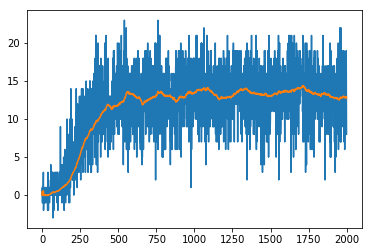

In [16]:
import matplotlib.pyplot as plt

x = range(len(scores))
plt.plot(x,scores, x,avg_scores)

#### Evaluation

The cell below creates a test agent loading the trained weights for a test run of the environment with the trained model. Change the num_episodes variable to run the simulation and calculate the average reward total over multiple episodes.

In [ ]:
test_agent = DQNAgent(state_size, action_size, "checkpoint.pth")
num_episodes = 1
total_scores = 0

for ep in range(num_episodes):
    env_info = env.reset(train_mode=True)[brain_name]
    state = env_info.vector_observations[0]
    total_reward = 0
    done = False
    while not done:
        action = test_agent.get_action(state)
        env_info = env.step(action)[brain_name]        
        next_state = env_info.vector_observations[0]   
        reward = env_info.rewards[0]                   
        done = env_info.local_done[0]   
        test_agent.train(state, action, next_state, reward, done)
        total_reward += reward                                
        state = next_state 

    total_scores += total_reward
    print("Episode: {}, Score: {}, Avg reward: {:.2f}".format(ep, scores[ep], avg_scores[ep]))
    
print("Average reward: {}".format(total_scores/num_episodes))

When finished, you can close the environment.

In [ ]:
env.close()